In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import cvxpy as cp
import pickle

Testing runtime scaling with the number of points and dimensions

In [8]:
num_points = 200
for dim in [4, 5, 6, 7]:
    points = np.random.uniform(size=(num_points, dim))
    start_time = time.time()
    vor = Voronoi(points)
    print('Dim %d: %.4fs' % (dim, time.time() - start_time))

Dim 4: 0.0506s
Dim 5: 0.1401s
Dim 6: 0.8386s
Dim 7: 5.9499s


In [4]:
dim = 6
for num_points in [100, 200, 300]:
    points = np.random.uniform(size=(num_points, dim))
    start_time = time.time()
    vor = Voronoi(points)
    print('Num points %d: %.4fs' % (num_points, time.time() - start_time))

Num points 100: 0.2524s
Num points 200: 0.8675s
Num points 300: 1.8501s


--- 

In [6]:
seed = 2019
np.random.seed(seed)

num_points = 100
dim = 2

# sample points from unifromly random distribution inside [0, 1] box
points = np.random.uniform(size=(num_points, dim))

# construct Voronoi diagram
vor = Voronoi(points)

## Dealing with infinite segments

`vor.ridge_points` identifies separating hyperplanes that the edges lie on  
`vor.rdige_vertices`

TODO: Now we skip infinite ridges

In [5]:
class VorLSH(object):
    def __init__(self, vor, params, seed=123):
        # set random seed for this LSH
        np.random.seed(seed)
        self.vor = vor
        self.dim = params['dim']
        self.num_proj = params['num_proj']
        self.bucket_size = params['bucket_size']
        self.max_bucket = 2 * np.ceil(
            np.sqrt(self.dim) / self.bucket_size).astype(np.int32) + 1
        # bucket goes from [- self.offset, self.offset + 1]
        self.offset = self.max_bucket // 2

        # init random projection lines passing through (0, 0)
        w = np.random.randn(self.num_proj, self.dim)
        self.w = w / np.linalg.norm(w, axis=1, keepdims=True)

        # naive implementation
        self.num_edges = len(vor.ridge_vertices)
        self.tab = np.zeros((self.num_proj, self.max_bucket, self.num_edges))
        for i, vertices in enumerate(vor.ridge_vertices):
            # TODO: we skip infinite ones for now
            if -1 in vertices:
                continue
            # get buckets for all vertices and projections
            # b has shape (num_proj, len(vertices))
            b = self.w @ vor.vertices[vertices].T
            b = (b // self.bucket_size).astype(np.int32)
            # b should be clipped to [- offset, offset]
            b = np.clip(b, - self.offset, self.offset)
            for j in range(self.num_proj):
                start = b[j].min() + self.offset
                stop = b[j].max() + self.offset
                self.tab[j, start:stop + 1, i] = 1

    def _check_bound(self, b):
        return (b >= - self.offset) * (b <= self.offset)
    
    def ridge_to_vertices(self, indices):
        """
        Take indices of ridges and return the corresponding
        sets of vertices that form each ridge
        """
        vertices = []
        for idx in indices:
            v = self.vor.ridge_vertices[idx]
            if -1 in v:
                raise ValueError('Something went wrong!')
            vertices.append(self.vor.vertices[v])
        return vertices

    def query(self, x):
        out = np.zeros((self.num_proj, self.num_edges))
        buckets = ((self.w @ x) // self.bucket_size).astype(np.int32)
        if not np.all(self._check_bound(buckets)):
            raise ValueError('Bucket is out of bound.')
        buckets += self.offset
        for i in range(self.num_proj):
            out[i] = self.tab[i, buckets[i]]
        return out
    
    def query_nearby(self, x, b):
        # count nearby buckets as a hit as well [-b, b]
        out = np.zeros((self.num_proj, self.num_edges))
        buckets = ((self.w @ x) // self.bucket_size).astype(np.int32)
        if not np.all(self._check_bound(buckets)):
            raise ValueError('Bucket is out of bound.')
        buckets += self.offset
        for i in range(self.num_proj):
            start = max(buckets[i] - b, 0)
            end = buckets[i] + b + 1
            out[i] = self.tab[i, start : end].sum(0)
        out = (out >= 1).astype(np.int32)
        return out

    def predict(self, x, b=0, idx=None):
        if b == 0:
            out = self.query(x)
        elif b > 0:
            out = self.query_nearby(x, b)
        else:
            raise ValueError('Invalid value for b (>= 0).')
        # do not break tie, only check if idx is in the top ties
        counts = out.sum(0)
        indices = np.nonzero(counts.max() == counts)[0]
        if idx is not None:
            return out, (idx in indices)
        else:
            return out

In [6]:
# find length of projected ridges
diam = []
w = np.random.randn(100, dim)
w = w / np.linalg.norm(w, axis=1, keepdims=True)

for i, vertices in enumerate(vor.ridge_vertices):
    # TODO: we skip infinite ones for now
    if -1 in vertices:
        continue
    b = w @ vor.vertices[vertices].T
    # this can be clip to reflect input domain [0, 1]
    b = np.clip(b, - np.sqrt(dim), np.sqrt(dim))
    diam.append(b.max(1) - b.min(1))
diam = np.concatenate(diam, axis=0)

In [7]:
np.sum([-1 not in v for v in vor.ridge_vertices])

8392

In [8]:
print('Average projected ridge length: %.4f' % diam.mean())
print('Median projected ridge length: %.4f' % np.median(diam))
print('Max projected ridge length: %.4f' % diam.max())
print('Min projected ridge length: %.4f' % diam.min())

Average projected ridge length: 0.7699
Median projected ridge length: 0.5195
Max projected ridge length: 4.8990
Min projected ridge length: 0.0000


In [581]:
params = {'dim': dim,
          'num_proj': 20,
          'bucket_size': 0.1}
lsh = VorLSH(vor, params, seed=seed)

In [9]:
def get_half_space(a, b):
    """
    Get hyperplane that w.T @ x = c and w points toward a
    """
    w = (b - a)
    c = np.dot(w.T, (a + b) / 2)
    sign = - np.sign(np.dot(w.T, b) - c)
    w = sign * w
    c = sign * c
    return [w, c]


def find_nearest_ridge(x, vor):
    """
    Find the nearest point on one of the ridges of the
    cell <x> is in
    """
    dim = len(x)
    num_points = len(vor.points)
    # find the cell x is in
    dist = np.linalg.norm(x - vor.points, axis=1)
    near_idx = dist.argmin()

    best_sol = 0
    best_dist = 1e5

    for j in range(num_points):
        if j == near_idx:
            continue
            
        # TODO: we skip infite ridge for now
        region = vor.regions[vor.point_region[j]]
        if -1 in region or not region:
            continue

        cur_point = vor.points[j]
        w_const = np.zeros((num_points, dim))
        c_const = np.zeros(num_points)
        for i, point in enumerate(vor.points):
            w, c = get_half_space(cur_point, point)
            w_const[i] = w
            c_const[i] = c
        # delete the nearest point itself
        w_const = np.delete(w_const, j, 0)
        c_const = np.delete(c_const, j, 0)

        # QP
        x_adv = cp.Variable(dim)
        constraint = [w_const @ x_adv >= c_const]
        prob = cp.Problem(cp.Minimize(cp.norm(x_adv - x)),
                          constraint)
        prob.solve()
        dist = prob.value
        if dist < best_dist:
            best_dist = dist
            best_sol = x_adv.value
            
    return best_sol


def check_sol(x, x_adv, vertices):
    """
    Check if <x_adv> found by the optimization is a
    projection of <x> on the ridge formed by <vertices>
    """
    d = x.shape[0]
    
    # project x onto hyperplane passing through the vertices
    # find the hyperplane w using pseudo-inverse (same as least square solution)
    w = np.linalg.pinv(vertices) @ np.ones(len(vertices))
    # sanity check
    if not np.allclose(vertices @ w, np.ones(len(vertices))):
        import pdb; pdb.set_trace()

    # check if x_adv is on hyperplane w
    return np.allclose(w @ x_adv, 1)


def check_candidates(x, x_adv, candidates):
    """
    Check if <x_adv> found by the optimization corresponds to 
    any of the <candidates> returned by the LSH.
    Return index of the matched candidate. Otherwise, return None.
    """
    for i, vertices in enumerate(candidates):
        if check_sol(x, x_adv, vertices):
            return i
    return None

In [583]:
# x = np.array([0.1, 0.1, 0.1, 0.1])
x = np.random.rand(dim)
x_adv = find_nearest_ridge(x, vor)

In [584]:
counts = lsh.query(x).sum(0)
top_counts = np.sort(np.unique(counts))[::-1]
ind_top1 = np.nonzero(top_counts[0] == counts)[0]
candidates = lsh.ridge_to_vertices(ind_top1)

In [585]:
for vertices in candidates:
    print(check_sol(x, x_adv, vertices))

False
False
False
False
False


In [586]:
num = 100
sum_out = 0
sum_max = 0
num_correct = 0
num_top1, num_top2, num_top3 = 0, 0, 0
num_correct_top2, num_correct_top3 = 0, 0

seed = 2019
np.random.seed(seed)

for i in range(num):
    x = np.random.uniform(size=(dim, ))
    x_adv = find_nearest_ridge(x, vor)

#     out = lsh.query(x)
    out = lsh.query_nearby(x, 1)
    counts = out.sum(0)
    top_counts = np.sort(np.unique(counts))[::-1]
    ind_top1 = np.nonzero(top_counts[0] == counts)[0]
    
    vert_top1 = lsh.ridge_to_vertices(ind_top1)
    match_top1 = check_candidates(x, x_adv, vert_top1)
    
    sum_out += out
    sum_max += counts.max()
    num_correct += (match_top1 is not None)
    
    try:
        ind_top2 = np.nonzero(top_counts[1] == counts)[0]
        vert_top2 = lsh.ridge_to_vertices(ind_top2)
        match_top2 = check_candidates(x, x_adv, vert_top2)
    except:
        ind_top2 = []
        match_top2 = match_top1
    try:
        ind_top3 = np.nonzero(top_counts[2] == counts)[0]
        vert_top3 = lsh.ridge_to_vertices(ind_top3)
        match_top3 = check_candidates(x, x_adv, vert_top3)
    except:
        ind_top3 = []
        match_top3 = match_top2

    num_correct_top2 += (match_top1 is not None or 
                         match_top2 is not None)
    num_correct_top3 += (match_top1 is not None or 
                         match_top2 is not None or
                         match_top3 is not None)

    num_top1 += len(ind_top1)
    num_top2 += len(ind_top2)
    num_top3 += len(ind_top3)
    
num_top2 += num_top1
num_top3 += num_top2

# number of collisions averaged over all projections
print('Average hits: %.2f' % (sum_out.sum(0).mean() / num))
print('Average max hits: %.2f' % (sum_max / num))
print('Accuracy: %.2f' % (num_correct / num))
print('Accuracy (top-2): %.2f' % (num_correct_top2 / num))
print('Accuracy (top-3): %.2f' % (num_correct_top3 / num))
print('Average number of candidates (top-1): %.2f' % (num_top1 / num))
print('Average number of candidates (top-2): %.2f' % (num_top2 / num))
print('Average number of candidates (top-3): %.2f' % (num_top3 / num))

Average hits: 7.33
Average max hits: 20.00
Accuracy: 0.98
Accuracy (top-2): 1.00
Accuracy (top-3): 1.00
Average number of candidates (top-1): 24.54
Average number of candidates (top-2): 43.08
Average number of candidates (top-3): 64.02


Comments
- Using more projections doesn't always help, or reduce the number of top-1 candidates (top-1 hits could reduce and become an inaccurate measure)
- Using "nearby buckets" increases accuracy as expected, and it is usually better than increasing bucket size (smaller number of top-1 candidates).
- Large number of projections would require larger bucket size and/or larger b
- Picking bucket size of 0.1 when average edge length is ~0.5 still feels too large

Results (dim = 4)
- `(num_proj=5, bucket_size=0.1, b=0)
Average hits: 1.27
Average max hits: 5.00
Accuracy: 0.84
Accuracy (top-2): 0.99
Accuracy (top-3): 1.00
Average number of candidates (top-1): 23.62
Average number of candidates (top-2): 94.11
Average number of candidates (top-3): 221.08`
- `(num_proj=5, bucket_size=0.1, b=1)
Average hits: 1.81
Average max hits: 5.00
Accuracy: 0.99
Accuracy (top-2): 1.00
Accuracy (top-3): 1.00
Average number of candidates (top-1): 73.27
Average number of candidates (top-2): 209.98
Average number of candidates (top-3): 397.70`
- `(num_proj=10, bucket_size=0.1, b=1)
Average hits: 3.69
Average max hits: 10.00
Accuracy: 0.99
Accuracy (top-2): 1.00
Accuracy (top-3): 1.00
Average number of candidates (top-1): 41.38
Average number of candidates (top-2): 85.18
Average number of candidates (top-3): 148.07`

Results (dim = 6)
- `(num_proj=10, bucket_size=0.1, b=0)
Average hits: 2.45
Average max hits: 10.00
Accuracy: 0.96
Accuracy (top-2): 0.98
Accuracy (top-3): 1.00
Average number of candidates (top-1): 60.18
Average number of candidates (top-2): 156.35
Average number of candidates (top-3): 274.72`
- `(num_proj=10, bucket_size=0.1, b=1)
Average hits: 3.03
Average max hits: 10.00
Accuracy: 1.00
Accuracy (top-2): 1.00
Accuracy (top-3): 1.00
Average number of candidates (top-1): 146.22
Average number of candidates (top-2): 308.81
Average number of candidates (top-3): 473.29`

ValueError: Voronoi diagram is not 2-D

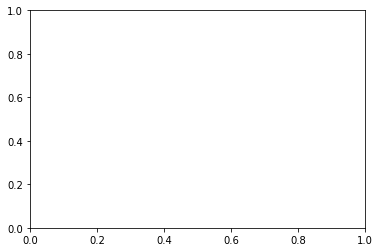

In [57]:
# only work with dim = 2

fig = voronoi_plot_2d(vor, show_vertices=False, show_points=True)
plt.scatter([x[0]], [x[1]], c='blue')
plt.scatter([x_adv[0]], [x_adv[1]], c='green')
for c in candidates:
    plt.scatter(c[:, 0], c[:, 1], c='red')
plt.show()

In [46]:
num_points = 100
dim = 6

seed = 123
np.random.seed(seed)

# sample points from unifromly random distribution inside [0, 1] box
points = np.random.uniform(size=(num_points, dim))
test_points = np.random.uniform(size=(num_points, dim))

# construct Voronoi diagram
vor = Voronoi(points)

params = {'dim': dim,
          'num_proj': 50,
          'bucket_size': 0.1}
lsh = VorLSH(vor, params, seed=seed)

qt = 0
num_top1 = 0
num_correct = 0

for i in range(num_points):
    
    x_adv = find_nearest_ridge(test_points[i], vor)
    start = time.time()
    out = lsh.query_nearby(test_points[i], 1)
    qt += time.time() - start
    counts = out.sum(0)
    top_counts = np.sort(np.unique(counts))[::-1]
    ind_top1 = np.nonzero(top_counts[0] == counts)[0]
    vert_top1 = lsh.ridge_to_vertices(ind_top1)
    match_top1 = check_candidates(test_points[i], x_adv, vert_top1)

    num_correct += (match_top1 is not None)
    num_top1 += len(ind_top1)
    
print(qt, num_top1 / num_points, num_correct)

0.14434432983398438 32.33 96


In [18]:
x = pickle.load(open('exact_dim2_ns100_seed123.p', 'rb'))

In [26]:
num_points = 100
dim = 2
seed = 123
np.random.seed(seed)
points = np.random.uniform(size=(num_points, dim))
test_points = np.random.uniform(size=(num_points, dim))

vor = Voronoi(points)
params = {'dim': dim,
          'num_proj': 50,
          'bucket_size': 0.1}
lsh = VorLSH(vor, params, seed=seed)

In [36]:
x_adv = find_nearest_ridge(test_points[1], vor)

In [43]:
test_points[1]

array([0.65336487, 0.99608633])

In [40]:
x

array([[[0.54263593, 0.06677444],
        [0.65336487, 0.99608633],
        [0.76939734, 0.57377411],
        [0.10263526, 0.69983407],
        [0.66116787, 0.04909713],
        [0.79229934, 0.51871658],
        [0.42586769, 0.78818717],
        [0.41156922, 0.48102628],
        [0.18162884, 0.3213189 ],
        [0.845533  , 0.18690375],
        [0.41729108, 0.98903452],
        [0.23660025, 0.91683267],
        [0.91839747, 0.09129634],
        [0.46365271, 0.50221629],
        [0.31366895, 0.04733954],
        [0.24168564, 0.09552964],
        [0.23824991, 0.80779108],
        [0.89497826, 0.04322289],
        [0.30194679, 0.98058218],
        [0.53950482, 0.62630936],
        [0.00554541, 0.48490944],
        [0.98833874, 0.37519884],
        [0.09703816, 0.46190876],
        [0.96300447, 0.34183062],
        [0.79892276, 0.79884633],
        [0.20824829, 0.4433677 ],
        [0.71560128, 0.41051979],
        [0.19100692, 0.96749431],
        [0.65075035, 0.86545983],
        [0.025

In [20]:
points = np.random.uniform(size=(5, 3))
vor = Voronoi(points)

In [21]:
vor.ridge_vertices

[[0, 1, -1], [0, 1, -1], [-1, 0, 1]]

In [27]:
points0 = np.array([[0, 0, 0], [0, 0, 1], [0, 0, -1],
                    [0, 1, 0], [0, 1, 1], [0, 1, -1],
                    [0, -1, 0], [0, -1, 1], [0, -1, -1]])
points1 = np.copy(points0)
points1[:, 0] += 1
points2 = np.copy(points0)
points2[:, 0] -= 1
points = np.concatenate([points0, points1, points2])

In [28]:
vor = Voronoi(points)

In [29]:
vor.ridge_vertices

# ridge_vertices excludes infinite ridge with only one vertex

# ridge_points -> 

[[0, 1, -1],
 [0, -1, 2],
 [0, 1, 3, 2],
 [2, 3, -1],
 [1, 3, -1],
 [1, 3, -1],
 [0, 2, -1],
 [0, 1, -1],
 [0, 4, -1],
 [0, 4, 5, 1],
 [1, 5, -1],
 [-1, 5, 4],
 [1, 5, -1],
 [0, 4, -1],
 [-1, 6, 7],
 [6, 7, -1],
 [2, 3, -1],
 [-1, 2, 7],
 [3, 2, 7, 6],
 [6, 3, -1],
 [4, -1, 5],
 [4, 7, -1],
 [4, 7, 6, 5],
 [5, 6, -1],
 [6, 3, -1],
 [2, 7, -1],
 [6, -1, 5],
 [0, 4, 7, 2],
 [1, 3, 6, 5],
 [-1, 4, 7]]

In [31]:
vor.points[vor.ridge_points[1]]

array([[ 0.,  1.,  0.],
       [-1.,  1.,  0.]])

In [34]:
vor.vertices[0], vor.vertices[2]

(array([-0.5,  0.5,  0.5]), array([-0.5,  0.5, -0.5]))

In [16]:
for i in [0, 4, 5, 1]:
    print(vor.vertices[i])

[-0.5  0.5  0.5]
[-0.5 -0.5  0.5]
[ 0.5 -0.5  0.5]
[0.5 0.5 0.5]


In [17]:
vor.regions

[[-1, 0, 1, 2, 3],
 [-1, 1, 3],
 [],
 [-1, 0, 2],
 [-1, 0, 1, 4, 5],
 [-1, 1],
 [-1, 1, 5],
 [-1, 0, 1],
 [-1, 0, 4],
 [-1, 0],
 [-1, 6, 7],
 [-1, 7],
 [-1, 6],
 [-1, 2, 3, 6, 7],
 [-1, 4, 5, 6, 7],
 [-1, 3],
 [-1, 3, 6],
 [-1, 2],
 [-1, 2, 3],
 [-1, 2, 7],
 [-1, 5, 6],
 [0, 1, 2, 3, 4, 5, 6, 7],
 [-1, 1, 3, 5, 6],
 [-1, 4, 7],
 [-1, 0, 2, 4, 7],
 [-1, 4, 5],
 [-1, 5],
 [-1, 4]]

In [26]:
vor.regions

[[-1, 0, 1, 2, 3],
 [-1, 1, 3],
 [],
 [-1, 0, 2],
 [-1, 0, 1, 4, 5],
 [-1, 1],
 [-1, 1, 5],
 [-1, 0, 1],
 [-1, 0, 4],
 [-1, 0],
 [-1, 6, 7],
 [-1, 7],
 [-1, 6],
 [-1, 2, 3, 6, 7],
 [-1, 4, 5, 6, 7],
 [-1, 3],
 [-1, 3, 6],
 [-1, 2],
 [-1, 2, 3],
 [-1, 2, 7],
 [-1, 5, 6],
 [0, 1, 2, 3, 4, 5, 6, 7],
 [-1, 1, 3, 5, 6],
 [-1, 4, 7],
 [-1, 0, 2, 4, 7],
 [-1, 4, 5],
 [-1, 5],
 [-1, 4]]

---

# Halfspace Intersection

In [3]:
from scipy.spatial import HalfspaceIntersection

In [14]:
# [A; b]
dim = 10
num_planes = 1000

halfspaces = np.random.randn(num_planes, dim)
halfspaces = np.concatenate([halfspaces, - np.ones((num_planes, 1))], axis=1)

feasible_point = np.zeros(dim)

In [15]:
start = time.time()
hs = HalfspaceIntersection(halfspaces, feasible_point)
end = time.time()
print(end - start)

755.7811999320984


In [23]:
import pyhull
from pyhull.halfspace import Halfspace, HalfspaceIntersection

In [24]:
hs_list = []
for i in range(num_planes):
    hs_list.append(Halfspace(halfspaces[i], -1))

In [25]:
start = time.time()
hs = HalfspaceIntersection(hs_list, feasible_point)
end = time.time()
print(end - start)

0.0004062652587890625


In [27]:
hs.vertices

array([], dtype=float64)

In [34]:
hs_list[1].offset

-1

In [38]:
pyhull.qhalf('Fp', hs_list, list(feasible_point))

['']

In [40]:
points = [list(h.normal) + [h.offset] for h in hs_list]

In [42]:
data = [[len(feasible_point), 1]]

In [44]:
data.append(map(repr, feasible_point))

In [46]:
data.append([len(points[0])])
data.append([len(points)])

In [51]:
data.extend([map(repr, row) for row in points])

In [56]:
prep_str = [" ".join(map(str, line)) for line in data]

In [64]:
import pyhull._pyhull as hull
output = getattr(hull, "qhalf")('Fx', "\n".join(prep_str))
print(output)